# <center><a name='temp_scrap'>Etude de données météorologiques: Recupération des données</a></center>

## <a name='temp_scrap_Sommaire'>1. Sommaire</a> <a href='#temp_scrap'>↑Haut</a>
<a href='#temp_scrap_Sommaire'>**1. Sommaire**</a>

<a href='#temp_scrap_lib_et_fonct'>**2. Librairies et fonctions**</a>

<a href='#temp_scrap_importation_et_prep'>**3. Importation des données**</a>
- <a href='#temp_scrap_climat'>**3.1. Les climats par station**</a>
- <a href='#temp_scrap_meteo_france'>**3.2. Récupération des données open data de météo france**</a>
- <a href='#temp_scrap_prep'>**3.3. Préparation des données**</a>

<a href='#temp_scrap_geo'>**4. Observation de la répartion des stations**</a>

<a href='#temp_scrap_write'>**5. Ecriture**</a>

## <a name='temp_scrap_lib_et_fonct'>**2. Librairies et fonctions**</a> <a href='#temp_scrap'>↑Haut</a>

In [3]:
# graph
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# carte
import folium
from branca.element import Template, MacroElement

# Dataframe
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# requetage
import requests
from time import sleep

# gestion des fichiers
import gzip
from os import listdir
from os.path import isfile, join

# bib
from utils.climat_color import climat_color
from toolbox.bib import histogramme_de_completion

In [95]:
def requete_station(df_station, start_date):
    start = start_date
    dt = datetime.strptime(start, "%Y-%m-%d") + timedelta(days=7)
    end=  dt.strftime("%Y-%m-%d")

    requete="https://www.infoclimat.fr/opendata/?method=get&format=json"

    for station_id in df_station:
        requete+= "&stations[]=" + station_id
        requete += "&start=" + start + "&end=" + end + "&token=L4m2akGkrBHRWWRgMs17eVilizqt65Vrd0U7mSdqHIa9fBMoEpt7w"

    return requests.get(requete).json()

In [96]:
def import_meteo_france(start_year, end_year, start_month, end_month):
    url= "https://donneespubliques.meteofrance.fr/donnees_libres/Txt/Synop/Archive/synop.202210.csv.gz"

    for annee in range(start_year,end_year + 1):
        for mois in range(start_month,end_month + 1):
            annee_mois=  f"{annee}"+ "{:02d}".format(mois)
            url= "https://donneespubliques.meteofrance.fr/donnees_libres/Txt/Synop/Archive/synop."+ annee_mois + ".csv.gz"
            response= requests.get(url)
            open("data/gz/synops"+ annee_mois +".gz", "wb").write(response.content)
            sleep(0.8)

## <a name='temp_scrap_importation_et_prep'>3. Importation des données</a> <a href='#temp_scrap'>↑Haut</a>

### <a name='temp_scrap_climat'>3.1. Les climats par station</a> <a href='#temp_scrap'>↑Haut</a>

Les stations représentent les différents climats en france continentale: 
 - climat océanique:
   - climat océanique nord-ouest
   - climat océanique aquitain
   - climat océanique dégradé
   - climat semi-continental
 - climat méditerranéen
 - climat de montagne (ou sous influence)

In [97]:
stations= pd.DataFrame(np.array([("07005", "ABBEVILLE", "océanique NO"), ("07015", "LILLE-LESQUIN", "océanique dégradé"),
                    ("07020", "PTE DE LA HAGUE", "océanique NO"), ("07027", "CAEN-CARPIQUET", "océanique NO"),
                    ("07037", "ROUEN-BOOS", "océanique dégradé"), 
                    ("07110", "BREST-GUIPAVAS", "océanique NO"), ("07130", "RENNES-ST JACQUES", "océanique NO"), 
                    ("07139", "ALENCON", "océanique dégradé"),("07149", "ORLY", "océanique dégradé"), 
                    ("07168", "TROYES-BARBEREY", "océanique dégradé"), ("07190", "STRASBOURG-ENTZHEIM", "semi-continental"),
                    ("07207", "BELLE ILE-LE TALUT", "océanique NO"), ("07222", "NANTES-BOUGUENAIS", "océanique NO"),
                    ("07240", "TOURS", "océanique NO"), ("07255", "BOURGES", "océanique dégradé"),
                    ("07280", "DIJON-LONGVIC", "semi-continental"), ("07299", "BALE-MULHOUSE", "semi-continental"),
                    ("07314", "PTE DE CHASSIRON", "océanique aquitain"), ("07335", "POITIERS-BIARD", "océanique NO"),
                    ("07434", "LIMOGES-BELLEGARDE", "océanique aquitain"), ("07460", "CLERMONT-FD", "océanique dégradé"),
                    ("07471", "LE PUY-LOUDES", "montagne"), ("07481", "LYON-ST EXUPERY", "semi-continental"),
                    ("07510", "BORDEAUX-MERIGNAC", "océanique aquitain"), ("07535", "GOURDON", "océanique aquitain"),
                    ("07558", "MILLAU", "montagne"), ("07577", "MONTELIMAR", "méditerranéen"),
                    ("07591", "EMBRUN", "montagne"), ("07607", "MONT-DE-MARSAN", "océanique aquitain"),
                    ("07621", "TARBES-OSSUN", "océanique aquitain"), ("07627", "ST GIRONS", "montagne"),
                    ("07630", "TOULOUSE-BLAGNAC", "méditerranéen"), ("07643", "MONTPELLIER", "méditerranéen"),
                    ("07650", "MARIGNANE", "méditerranéen"), ("07661", "CAP CEPET", "méditerranéen"),
                    ("07117", "PLOUMANAC'H - PERROS", "océanique NO"), ("07181", "NANCY-OCHEY", "semi-continental"),
                    ("07690", "NICE", "méditerranéen"), ("07747", "PERPIGNAN", "méditerranéen")]),
                       columns=["id_sta", "station", "climat"])
stations.head()

,id_sta,station,climat
0,07005,ABBEVILLE,océanique NO
1,07015,LILLE-LESQUIN,océanique dégradé
2,07020,PTE DE LA HAGUE,océanique NO
3,07027,CAEN-CARPIQUET,océanique NO
4,07037,ROUEN-BOOS,océanique dégradé


### <a name='temp_scrap_recup'>3.2. Récupération des données</a> <a href='#temp_scrap'>↑Haut</a>
#### <a name='temp_scrap_meteo_france'>3.2. Meteo france open data</a> <a href='#temp_scrap'>↑Haut</a>

In [98]:
# import des fichiers depuis meteo france
#import_meteo_france(1996, 2021, 1, 12)
#import_meteo_france(2022,2022, 1, 9)

In [99]:
# # transformation et fusion en csv
# columns_to_keep= ["numer_sta", "date", "t", "tn12", "tn24", "tx12", "tx24"]
# meteo_data= pd.DataFrame(columns=columns_to_keep)

# path= "data/gz/"
# onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
# for i in range(0,len(onlyfiles)):
#     print(f"\rFichier {i+1}/{len(onlyfiles)} soit: {round((i+1)/len(onlyfiles)*100)}/100%", end="")
#     with gzip.open(path + onlyfiles[i], "rt", newline="") as csv_file:
#         meteo_data= pd.concat([meteo_data, pd.read_csv(csv_file, sep= ";")[columns_to_keep]], ignore_index=True)
# meteo_data

In [100]:
# # sauvegarde des données
# meteo_data.to_csv("data/meteo_data.csv")

In [101]:
meteo_data= pd.read_csv("data/meteo_data.csv", index_col=0)

meteo_data.head(5)

,numer_sta,date,t,tn12,tn24,tx12,tx24
0,7005,19960101000000,276.040000,mq,mq,mq,mq
1,7015,19960101000000,275.950000,mq,mq,mq,mq
2,7020,19960101000000,281.650000,mq,mq,mq,mq
3,7027,19960101000000,279.040000,mq,mq,mq,mq
4,7037,19960101000000,278.540000,mq,mq,mq,mq


#### <a name='temp_scrap_info_climat'>3.2. Info climat</a> <a href='#temp_scrap'>↑Haut</a>

In [102]:
# conversion des id en chaine de caractère
meteo_data["numer_sta"]= meteo_data["numer_sta"].astype(str).str.zfill(5)

In [103]:
# filtrage les stations utlisées
meteo_data= meteo_data.loc[meteo_data.numer_sta.isin(stations.id_sta.unique())]

In [104]:
json_result= requete_station(meteo_data.numer_sta.unique(), "2022-01-01")

In [105]:
stations= pd.merge(
    stations, 
    pd.DataFrame(json_result["stations"]
                ).drop(columns=["elevation", "type", "license"]), 
    left_on="id_sta", 
    right_on="id" ,
    how="outer")

In [106]:
stations["name"]= stations["name"].astype(str)

In [107]:
stations.head(5)

,id_sta,station,climat,id,name,latitude,longitude
0,07005,ABBEVILLE,océanique NO,07005,Abbeville,50.133,1.837
1,07015,LILLE-LESQUIN,océanique dégradé,07015,Lille-Lesquin,50.575,3.092
2,07020,PTE DE LA HAGUE,océanique NO,07020,Cap de La Hague,49.727,-1.940
3,07027,CAEN-CARPIQUET,océanique NO,07027,Caen-Carpiquet,49.182,-0.463
4,07037,ROUEN-BOOS,océanique dégradé,07037,Rouen-Boos,49.383,1.182


### <a name='temp_scrap_prep'>3.3. Préparation des données</a> <a href='#temp_scrap'>↑Haut</a>

#### Typage des dates

In [108]:
meteo_data.date= pd.to_datetime(meteo_data.date, format="%Y%m%d%H%M%S")
meteo_data

,numer_sta,date,t,tn12,tn24,tx12,tx24
0,07005,1996-01-01 00:00:00,276.040000,mq,mq,mq,mq
1,07015,1996-01-01 00:00:00,275.950000,mq,mq,mq,mq
2,07020,1996-01-01 00:00:00,281.650000,mq,mq,mq,mq
3,07027,1996-01-01 00:00:00,279.040000,mq,mq,mq,mq
4,07037,1996-01-01 00:00:00,278.540000,mq,mq,mq,mq
...,...,...,...,...,...,...,...
4497122,07643,2022-09-30 21:00:00,289.050000,mq,mq,mq,mq
4497123,07650,2022-09-30 21:00:00,287.550000,mq,mq,mq,mq
4497124,07661,2022-09-30 21:00:00,mq,mq,mq,mq,mq
4497125,07690,2022-09-30 21:00:00,292.350000,mq,mq,mq,mq


#### Typage des temperatures

In [109]:
# typage
var_temp= ["t", "tn12", "tn24", "tx12", "tx24"]
for var in var_temp:
    meteo_data[var]= pd.to_numeric(meteo_data[var], errors="coerce")

meteo_data.loc[meteo_data.t.isna()].head(5)

,numer_sta,date,t,tn12,tn24,tx12,tx24
6152,07690,1996-01-14 21:00:00,NaN,NaN,NaN,NaN,NaN
6208,07690,1996-01-15 00:00:00,NaN,NaN,NaN,NaN,NaN
6264,07690,1996-01-15 03:00:00,NaN,NaN,NaN,NaN,NaN
6317,07690,1996-01-15 06:00:00,NaN,NaN,NaN,NaN,NaN
6427,07690,1996-01-15 12:00:00,NaN,NaN,NaN,NaN,NaN


In [110]:
# conversion en Celcius
for var in var_temp:
    meteo_data[var] = meteo_data[var] - 273.15
meteo_data.head(5)

,numer_sta,date,t,tn12,tn24,tx12,tx24
0,07005,1996-01-01,2.89,NaN,NaN,NaN,NaN
1,07015,1996-01-01,2.80,NaN,NaN,NaN,NaN
2,07020,1996-01-01,8.50,NaN,NaN,NaN,NaN
3,07027,1996-01-01,5.89,NaN,NaN,NaN,NaN
4,07037,1996-01-01,5.39,NaN,NaN,NaN,NaN


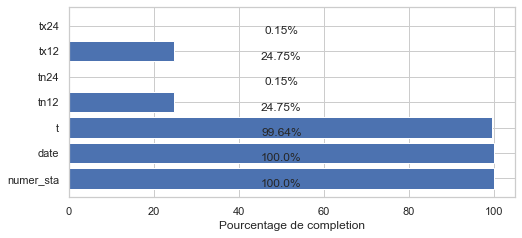

In [111]:
histogramme_de_completion(meteo_data, prct=True)

Trop peu de valeurs pour certaines colonnes. Elles ne sont pas exploitable.

In [112]:
meteo_data.drop(columns=["tx24", "tx12", "tn24", "tn12"], inplace=True)

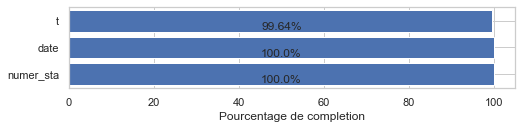

In [113]:
histogramme_de_completion(meteo_data, prct=True)

In [114]:
meteo_data.dropna(inplace=True)

#### Création du Dataframe final

In [115]:
meteo_data= pd.merge(
    stations, 
    meteo_data, 
    left_on="id_sta", 
    right_on="numer_sta", 
    how="inner"
).drop(columns=["numer_sta", "station", "id", "latitude", "longitude"])
meteo_data.head(5)

,id_sta,climat,name,date,t
0,07005,océanique NO,Abbeville,1996-01-01 00:00:00,2.89
1,07005,océanique NO,Abbeville,1996-01-01 03:00:00,2.70
2,07005,océanique NO,Abbeville,1996-01-01 06:00:00,2.89
3,07005,océanique NO,Abbeville,1996-01-01 09:00:00,3.60
4,07005,océanique NO,Abbeville,1996-01-01 12:00:00,4.39


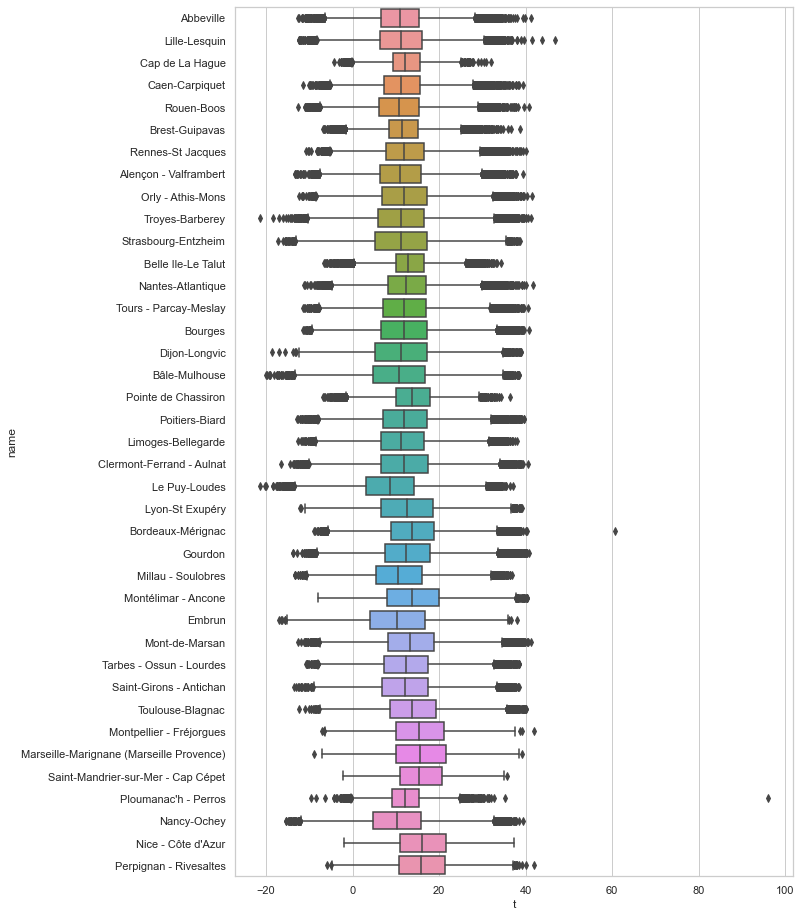

In [116]:
sns.set_theme(style="whitegrid")
fig= plt.figure(figsize=(10,16))
sns.boxplot(x=meteo_data.t, y=meteo_data.name, orient='h')
plt.show()

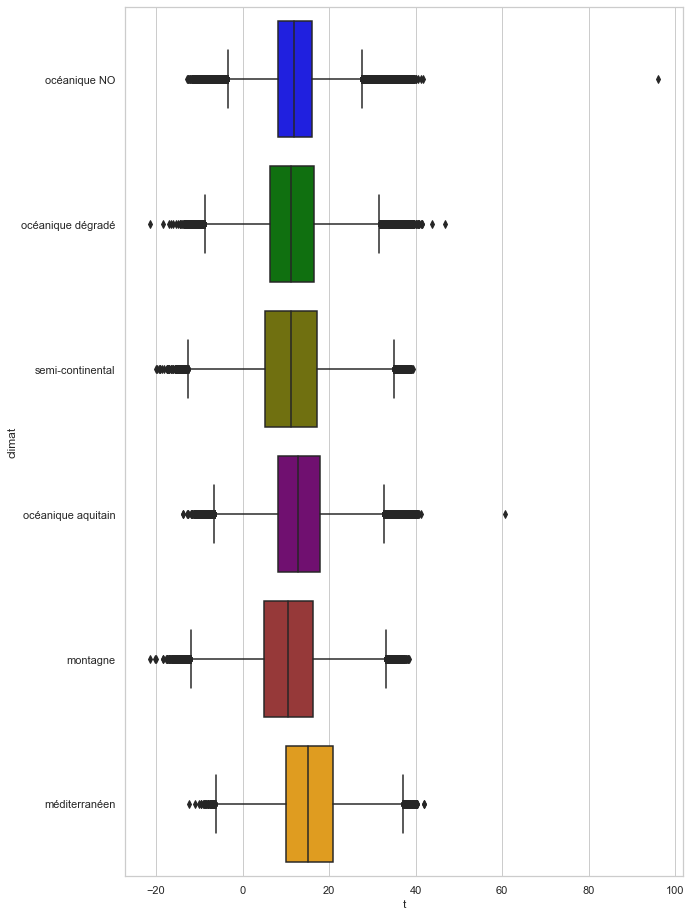

In [117]:
sns.set_theme(style="whitegrid")
fig= plt.figure(figsize=(10,16))
sns.boxplot(x=meteo_data.t, y=meteo_data.climat, palette= climat_color,orient='h')
plt.show()

In [118]:
meteo_data.loc[meteo_data.t > 42]

,id_sta,climat,name,date,t
105002,07015,océanique dégradé,Lille-Lesquin,2005-05-27 21:00:00,43.8
105003,07015,océanique dégradé,Lille-Lesquin,2005-05-28 00:00:00,46.9
1782358,07510,océanique aquitain,Bordeaux-Mérignac,1996-03-09 15:00:00,60.8
2702303,07117,océanique NO,Ploumanac'h - Perros,1996-01-07 06:00:00,96.0


In [119]:
meteo_data = meteo_data.loc[~(meteo_data.t > 42)]

## <a name='temp_scrap_geo'>4. Observation de la répartion des stations</a> <a href='#temp_scrap'>↑Haut</a>

Affichage de la carte des stations

In [120]:
lat_mean= stations.latitude.mean()
long_mean= stations.longitude.mean()
fig = folium.Figure(width=800, height=800)
france_map= folium.Map( location=[lat_mean, long_mean], zoom_start=6)
fig.add_child(france_map)
stations_points= folium.map.FeatureGroup()

for i, row in stations.iterrows():
    stations_points.add_child(
        folium.features.CircleMarker(
            location=[row.latitude, row.longitude], radius=5, color="grey", popup=folium.Popup(row["name"], parse_html=True),
            fill="True", fill_color=climat_color[row.climat], fill_opacity=1
        )
    )

france_map.add_child(stations_points)


template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Climat</div>
<div class='legend-scale'>
  <ul class='legend-labels'>"""
for climat, couleur in climat_color.items():
    template+= "<li><span style='background:"+ couleur +";opacity:0.7;'></span>"+ climat +"</li>"
    
template+= """  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

france_map.get_root().add_child(macro)

france_map

## <a name='temp_scrap_write'>5. Ecriture</a> <a href='#temp_scrap'>↑Haut</a>

In [121]:
meteo_data.head(5)

,id_sta,climat,name,date,t
0,07005,océanique NO,Abbeville,1996-01-01 00:00:00,2.89
1,07005,océanique NO,Abbeville,1996-01-01 03:00:00,2.70
2,07005,océanique NO,Abbeville,1996-01-01 06:00:00,2.89
3,07005,océanique NO,Abbeville,1996-01-01 09:00:00,3.60
4,07005,océanique NO,Abbeville,1996-01-01 12:00:00,4.39


In [123]:
meteo_data.to_csv("data/meteorological_data.csv", index=False)